In [15]:
# %pip install scikit-learn
# %pip install matplotlib
# %pip install tqdm torch numpy

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.metrics import f1_score
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import torch.nn.functional as F

In [17]:
with open('train_dict.pkl', 'rb') as f:
    train_data = pickle.load(f, encoding='latin1')

with open('val_dict.pkl', 'rb') as f:
    val_data = pickle.load(f, encoding='latin1')

with open('val_dict.pkl', 'rb') as f:
    val_without_pad = pickle.load(f, encoding='latin1')

emotion_ids = {'neutral' : 0, 'joy' : 1, 'anger' : 2, 'surprise' : 3, 'sadness' : 4, 'fear' : 5, 'disgust' : 6}

In [18]:
def pad_data():
    max_length = 25
    pad_word = 'PAD'
    pad_emotion = 'neutral'
    data = [train_data, val_data]
    dict_ = {}

    for task_data in data:
        remove_keys = []
        for key in task_data:
            if len(task_data[key][0]) not in dict_:
                dict_[len(task_data[key][0])] = 0
            dict_[len(task_data[key][0])] += 1
            # checking_nan
            for step in range(len(task_data[key][3])):
                if task_data[key][3][step] is None:
                    remove_keys.append(key)
                    
              
            for step in range(len(task_data[key][0]), max_length):
                task_data[key][0].append(pad_word)
                task_data[key][1].append(np.zeros(768))
                task_data[key][2].append(pad_emotion)
                task_data[key][3].append(0)
        
        for key in remove_keys:
            if key in task_data:
                del task_data[key] 

def remove_nan():
    data = [val_without_pad]
    dict_ = {}

    for task_data in data:
        remove_keys = []
        for key in task_data:
            if len(task_data[key][0]) not in dict_:
                dict_[len(task_data[key][0])] = 0
            dict_[len(task_data[key][0])] += 1
            # checking_nan
            for step in range(len(task_data[key][3])):
                if task_data[key][3][step] is None:
                    remove_keys.append(key)
                
        
        for key in remove_keys:
            if key in task_data:
                del task_data[key]  


pad_data()
remove_nan()
train_data = {new_key: train_data[old_key] for new_key, (old_key, _) in enumerate(train_data.items())}
val_data = {new_key: val_data[old_key] for new_key, (old_key, _) in enumerate(val_data.items())}
val_without_pad = {new_key: val_without_pad[old_key] for new_key, (old_key, _) in enumerate(val_without_pad.items())}

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(embedding_dim, 256, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(256, 64, num_layers=1, batch_first=True)
        # self.lstm3 = nn.LSTM(128, 64, num_layers=1, batch_first=True)
        self.lstm4 = nn.LSTM(64, 16, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(16, num_classes)
        # self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        # out, _ = self.lstm3(out)
        out, _ = self.lstm4(out)
        out = self.fc1(out)   # Taking only the last time step output
        # out = self.fc2(out)
        out = F.softmax(out, dim=-1)
        return out

In [20]:
class ErfDataset(Dataset):
    def __init__(self, data, emo_index):
        self.data = data
        self.length = len(self.data)
        self.emo_index =  emo_index

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        sentence_embeddings = np.array(self.data[index][1] , dtype='float32')
        emotion_sequence = self.data[index][2]
        emotion_labels = [self.emo_index[emotion] for emotion in emotion_sequence]
        return torch.tensor(sentence_embeddings, dtype= torch.float32), torch.tensor(emotion_labels, dtype= torch.float32)

In [21]:
train_dataset = ErfDataset(train_data, emotion_ids)
val_dataset = ErfDataset(val_data, emotion_ids)
val_without_pad_dataset = ErfDataset(val_without_pad, emotion_ids)

In [22]:
def plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores):

    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(train_dataset, val_dataset, model, optimizer, criterion, device, num_epochs = 30, bs = 32):

    train_dataloader = DataLoader(train_dataset, batch_size = bs, shuffle = True)
    val_dataloader =  DataLoader(val_dataset, batch_size = bs, shuffle = False)

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()  
        total_train_loss = 0
        all_train_predictions = []
        all_train_targets = []

        for batch_idx, (inputs, emotions) in enumerate(train_dataloader):
            inputs, emotions = inputs.to(device), emotions.to(device)
            # print(f"inputs shape - {inputs.shape}")
            # print(f"emotions shape - {emotions.shape}")
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # print(f"outputs shape - {outputs.shape}")
            loss = 0
    
            # Iterate over time steps
            for i in range(outputs.size(1)):
                # print(outputs[:, i, :].shape)
                # print(emotions[:, i].long().shape)
                loss += criterion(outputs[:, i, :], emotions[:, i].long())
            
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            predictions = outputs.argmax(dim=2).view(-1).cpu().numpy()
            targets = emotions.view(-1).cpu().numpy()

            all_train_predictions.extend(predictions)
            all_train_targets.extend(targets)

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        train_macro_f1 = f1_score(all_train_targets, all_train_predictions, average='weighted')
        train_f1_scores.append(train_macro_f1)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Training Macro F1-Score: {train_macro_f1}")

        model.eval()  
        total_val_loss = 0
        all_val_predictions = []
        all_val_targets = []

        with torch.no_grad():
            for val_inputs, val_emotions in val_dataloader:
                val_inputs, val_emotions = val_inputs.to(device), val_emotions.to(device)
                val_outputs = model(val_inputs)

                # Compute loss
                loss = 0
        
                # Iterate over time steps
                for i in range(val_outputs.size(1)):
                    loss += criterion(val_outputs[:, i, :], val_emotions[:, i].long())

                # loss = criterion(val_outputs.view(-1, val_outputs.size(2)), val_emotions.view(-1))
                total_val_loss += loss.item()

                # Convert predictions and targets to numpy arrays
                predictions = val_outputs.argmax(dim=2).view(-1).cpu().numpy()
                targets = val_emotions.view(-1).cpu().numpy()

                all_val_predictions.extend(predictions)
                all_val_targets.extend(targets)

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)

            # Calculate F1 score
            val_macro_f1 = f1_score(all_val_targets, all_val_predictions, average='weighted')
            val_f1_scores.append(val_macro_f1)

        print(f"Epoch {epoch + 1},  Validation Loss: {avg_val_loss}, Validation Macro F1-Score: {val_macro_f1}")


    plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores)
    return train_losses, train_f1_scores, val_losses, val_f1_scores


def test_model(test_dataset, model, device):
    test_dataloader = None
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


    total_test_loss = 0
    all_test_predictions = []
    all_test_targets = []

    with torch.no_grad():
        for test_inputs, test_emotions in test_dataloader:
            test_inputs, test_emotions = test_inputs.to(device), test_emotions.to(device)
            test_outputs = model(test_inputs)
            all_test_predictions.extend(test_outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_test_targets.extend(test_emotions.view(-1).cpu().numpy())

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_macro_f1 = f1_score(all_test_targets, all_test_predictions, average='weighted')
    print(f'Test Loss: {avg_test_loss}, Test Macro F1-Score: {test_macro_f1}')

In [23]:
# device = torch.device(
#     "mps"
#     if torch.backends.mps.is_available()
#     else "cuda" if torch.cuda.is_available() else "cpu"
# )

# model = LSTMModel(768, 7).to(device) 
# optimizer = optim.Adam(model.parameters(), lr = 0.0005)
# criterion = nn.CrossEntropyLoss()

# train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(train_dataset, val_dataset, model = model, num_epochs = 80, optimizer=optimizer, criterion=criterion, device=device)

# torch.save(model.state_dict(), 'model_m1_dict.pt')

Epoch 1, Training Loss: 39.92188894839687, Training Macro F1-Score: 0.7081445485677482
Epoch 1,  Validation Loss: 36.001543925358696, Validation Macro F1-Score: 0.7191713389412965
Epoch 2, Training Loss: 35.25373540397819, Training Macro F1-Score: 0.7142164871666569
Epoch 2,  Validation Loss: 34.72314775907076, Validation Macro F1-Score: 0.7191713389412965
Epoch 3, Training Loss: 34.60884271869222, Training Macro F1-Score: 0.7142164871666569
Epoch 3,  Validation Loss: 34.39637638972356, Validation Macro F1-Score: 0.7191713389412965
Epoch 4, Training Loss: 34.39350512555537, Training Macro F1-Score: 0.7142164871666569
Epoch 4,  Validation Loss: 34.25217012258676, Validation Macro F1-Score: 0.7191713389412965
Epoch 5, Training Loss: 34.27498201559518, Training Macro F1-Score: 0.7167121120585874
Epoch 5,  Validation Loss: 34.172348315899185, Validation Macro F1-Score: 0.7221144755770486
Epoch 6, Training Loss: 34.222234391074146, Training Macro F1-Score: 0.7206649615793786
Epoch 6,  Valid

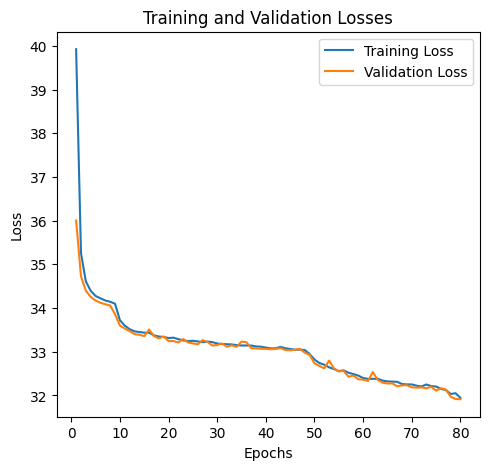

In [24]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

model = LSTMModel(768, 7).to(device) 
optimizer = optim.Adam(model.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss()

train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(train_dataset, val_dataset, model = model, num_epochs = 80, optimizer=optimizer, criterion=criterion, device=device)

torch.save(model.state_dict(), 'model_m1_dict.pt')

In [26]:
loaded_model = LSTMModel(768, 7).to(device) 
loaded_model.load_state_dict(torch.load('model_m1_dict.pt'))
test_model(val_without_pad_dataset, loaded_model, device)

Test Loss: 0.0, Test Macro F1-Score: 0.6203351842352914
